In [54]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [55]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [56]:
DATASET_NAME = 'cstr'

In [57]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=5)

In [58]:
# print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
print(test_labels['label'])

node_id    timestamp
node_1_10  0             N
node_1_11  0             N
node_1_12  0             N
node_1_13  0             N
node_1_14  0             N
                        ..
node_9_95  0            F9
node_9_96  0            F9
node_9_97  0            F9
node_9_98  0            F9
node_9_99  0            F9
Name: label, Length: 855, dtype: object


In [59]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [60]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] .......... (step 2 of 5) Processing features, total=   8.7s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [61]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


In [62]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.24331977700410518
F1 0.0
F2 0.8857142857142857
F3 0.0
F4 0.7337278106508875
F5 0.0
F6 0.0
F7 0.043478260869565216
F8 0.0
F9 0.0
N 0.37017994858611825


In [63]:
label_list = pipeline.steps[4][1].classes_
label_list[1]

'F2'

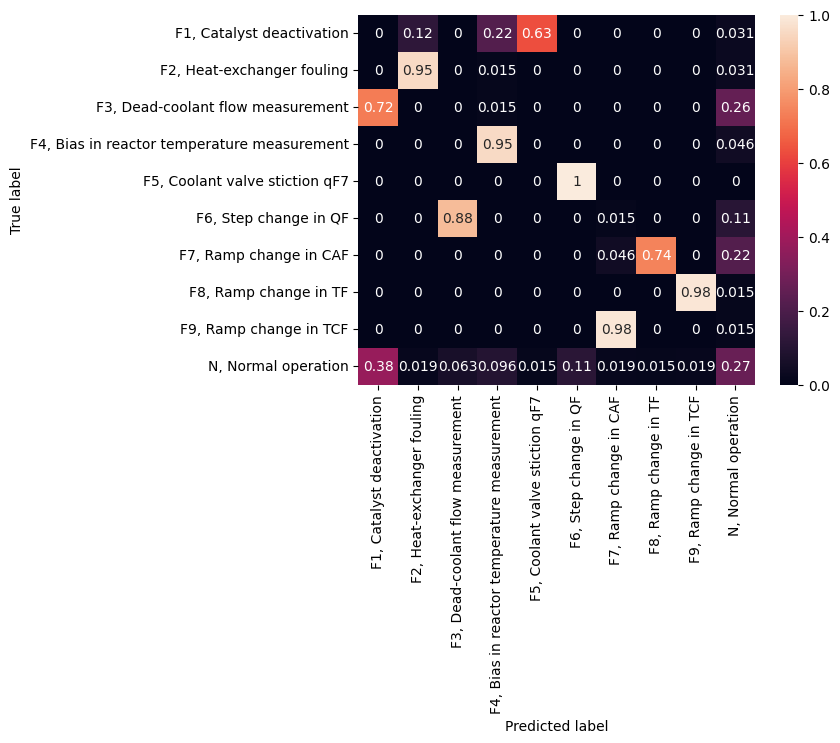

In [69]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'N': 'N, Normal operation', 'F1': 'F1, Catalyst deactivation', 'F2': 'F2, Heat-exchanger fouling', 'F3': 'F3, Dead-coolant flow measurement', 'F4': 'F4, Bias in reactor temperature measurement', 'F5': 'F5, Coolant valve stiction qF7', 'F6': 'F6, Step change in QF', 'F7': 'F7, Ramp change in CAF', 'F8': 'F8, Ramp change in TF', 'F9': 'F9, Ramp change in TCF'}
# label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}

text_labels = [label_dict[str(i)] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [70]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [71]:
test_labels['label']

node_id    timestamp
node_1_10  0             N
node_1_11  0             N
node_1_12  0             N
node_1_13  0             N
node_1_14  0             N
                        ..
node_9_95  0            F9
node_9_96  0            F9
node_9_97  0            F9
node_9_98  0            F9
node_9_99  0            F9
Name: label, Length: 855, dtype: object

In [72]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 'N' #UPDATE HERE FOR OTHER CLASSES
pred_select = 'F1' #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_13', 3], ['node_1_14', 4], ['node_1_15', 5], ['node_1_22', 12], ['node_1_23', 13], ['node_1_24', 14], ['node_1_25', 15], ['node_1_26', 16], ['node_1_27', 17], ['node_1_28', 18], ['node_1_29', 19], ['node_1_30', 20], ['node_1_34', 24], ['node_2_13', 98], ['node_2_14', 99], ['node_2_15', 100], ['node_2_22', 107], ['node_2_23', 108], ['node_2_24', 109], ['node_2_25', 110], ['node_2_26', 111], ['node_2_27', 112], ['node_2_28', 113], ['node_2_29', 114], ['node_2_30', 115], ['node_2_34', 119], ['node_3_13', 193], ['node_3_14', 194], ['node_3_15', 195], ['node_3_22', 202], ['node_3_23', 203], ['node_3_24', 204], ['node_3_25', 205], ['node_3_26', 206], ['node_3_27', 207], ['node_3_28', 208], ['node_3_29', 209], ['node_3_30', 210], ['node_3_34', 214], ['node_3_6', 241], ['node_3_7', 252], ['node_3_8', 263], ['node_3_9', 274], ['node_4_13', 288], ['node_4_14', 289], ['node_4_15', 290], ['node_4_22', 297], ['node_4_23', 298], ['node_4_24', 299], ['node_4_25', 300], ['node_4_26', 301], [

In [73]:
x_test = test_timeseries.loc[['node_1_26'], :, :]
explanation = comte.explain(x_test,to_maximize=pred_select,savefig=False) 
print('###########')
print(explanation)
print('###########')

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-20 18:06:23,045 INFO    Working on turning label from 9 to F1
/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Preci

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices